In [ ]:
# !pip install gpboost

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from scipy.stats import norm
import sklearn as sk
import xgboost as xgb
import lightgbm as lgb
from sklearn import preprocessing, model_selection, multioutput, linear_model, decomposition, multioutput
# below added after submission
import statsmodels
from statsmodels.datasets import grunfeld
# import gpboost as gpb
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [ ]:
!python --version
tf.version.VERSION, np.version.version

Python 3.7.13


('2.8.0', '1.21.6')

In [ ]:
# !pip freeze > requirements.txt

# **Global Study Parameters and Patient Obj**

In [ ]:
''' RUN THIS CELL '''
# Global constant for parameters of longitudinal study (control total repeated measures)
TOTAL_OBS_PERIOD = 120 # Total number of months study runs
MEASUREMENT_INTERVAL = 6 # Interval in months at which they take measurements (in theory) 

My general thesis on choosing values for the underlying parameters (and distributions on) were that patients would generally have been prescreened and singled out to already because they exhibits some evolutionary behavior. Thus there is probably a significant starting value (relatively). But after some inflection point $t_k$ is when the evolutionary rate really starts to increase (or speed up over time). \\
$m_0 \sim U(0.3, 0.5)$ \\
$m_1 \sim N(\phi, m_0)$ \\
$b_0 = 0.5$ \\
$b_1 = (m_0 - m_1)t_k + b_0$ \\
$k = 0.7$

In [ ]:
''' RUN THIS CELL '''

class patient:
    ''' Used for generating patient objects, each with unique evolutionary rates
        of the ground truth biomarker. 
    '''
    def __init__(self) -> None:
        self.division_point = 0.7 # The point, k, at which the piecewise function divides.
        self.rng = np.random.default_rng()
        self.phi = 1.618033988749895 # A little golden ratio flair for fun.
        
        # Biomarker info
        # 0 <= t <= t_k piecewise parameters (below)
        self.m0, self.b0 = self.rng.uniform(low = 0.3, high = 0.5), self.rng.uniform(low = 0.4, high = 0.5)
        # t_k <= t <= 1 piecewise parameters (below)
        self.m1 = self.rng.normal(self.phi, self.m0) #self.rng.uniform(low = self.m0, high = self.phi)
        self.b1 = (self.m0 - self.m1)*self.division_point + self.b0
        
        # Patient info
        self.age = np.random.randint(low = 20, high = 40 + 1)
        self.gender = self.rng.binomial(n = 1, p = 0.5)
        # Data taken from https://www.cdc.gov/nchs/fastats/body-measurements.htm
        # 'Avg' US male height ~175 cm, women ~161 cm (for white males/females)
        self.height = self.rng.normal(175, 7) if self.gender == 1 else self.rng.normal(161, 7)
        # 'Avg' US male weight ~200 lbs, women ~171 lbs (for white males/females)
        self.weight = self.rng.normal(200, 10) if self.gender == 1 else self.rng.normal(171, 10)

# **Biomarker 'truth' model**

In [ ]:
''' RUN THIS CELL '''

def biomarker_truth_model(patient: object, unit_time: float) -> float:
    ''' Takes in a unit time on [0,1] and returns the "true" biomarker history 
        for a patient at any desired point on the unit interval.

        ### Parameters:
        patient: object
            Contains all of the ground truth rates of evolution for the given
            patient.
        unit_time: float
            Time, unitized by length of observational period.
        model: string
            - 'liner' for a piecewise linear.
            - 'rwalk' for random walk process.
        
        ### Returns:
        biomarker: float
            "True" biomarker for given patient at desired unit time point.
    '''

    # For time between 0 <= t <= t_k
    if unit_time <= patient.division_point: return patient.m0*unit_time + patient.b0
    # For time between t_k <= t <= 1
    else: return patient.m1*unit_time + patient.b1

# **Clinical measurement model**

In [ ]:
''' RUN THIS CELL '''

def clinical_measurement_model(patient: object, total_measurements: int, measurement_interval: int) -> np.ndarray:
    ''' Takes in a patient record/object and the number of total measurements conducted
        in the study and returns the observed biomarker measurements which account
        for error caused by intrumentation error, test protocols, individual biology, etc.

        ### Parameters:
        patient: object
            Contains all of the ground truth rates of evolution for the given
            patient.
        total_measurements: int
            Number of total measurements taken throughout the study.
        measurement_interval: int
            Number of months at which a patient will come in for observations/
            measurements (in theory).

        ### Returns
        actual_measurements: np.ndarray
            The actual measurements throughout the study accounting for timing
            conflicts, as well as measurement error.
        adjusted_unit_schedule: np.ndarray
            The actual times at which patients came into be measured relative to
            the theorhetical observational schedule.
    '''
    rng = np.random.default_rng()
    dt = measurement_interval # Delta t
    true_timing_schedule = np.arange(0, dt*total_measurements, dt)  # Monthly intervals at which patients would optimally get measured
    scheduling_variability =  rng.normal(0, 0.1, size = len(true_timing_schedule)) # Variabilty in clinic visit by month (fractions of)
    noisy_timing_schedule = true_timing_schedule + scheduling_variability # Actual patient schedule (w/ noise)

    # Since in all probability, only the first measurment might be negative,
    # relative to a zero start date, we just say the initial measurement is a t_0
    # and adjust the rest of the visits from there.
    adjusted_unit_schedule = np.where(noisy_timing_schedule >= 0, 
                                      noisy_timing_schedule / np.max(noisy_timing_schedule), 0)
    noisy_measurements = np.array([biomarker_truth_model(patient, adj_unit_time) for adj_unit_time in adjusted_unit_schedule])
    measurement_variability = rng.normal(0, 0.25, size = len(noisy_measurements))

    # I think I need to return the noisy time as well so that when I convert
    # the data to a long format I have something more granular
    return noisy_measurements + measurement_variability, adjusted_unit_schedule

# **Helper and Transformation Functions**

In [ ]:
''' RUN THIS CELL '''

def generate_patients(num_patients: int) -> np.ndarray:
    ''' Generates N unique patient record objects.

        ### Parameters
        num_patients: int
            Number of patient objects to be generated.

        ### Returns
        patient_records: np.ndarray
            (N x 1) np.ndarray containing patient() objects.
    '''
    patient_records = np.array([patient() for pat in range(num_patients)])

    return patient_records

def generate_longitudinal_dataset(patients: np.ndarray, observational_period: int, measurement_interval: int) -> np.ndarray:
    ''' Generates a wide format longitudinal data set combining information form
        unique patient records with the clinical measurements.

        ### Parameters
        patients: np.ndarray
            An (N x 1) array storing all of the patient records as objects.
        observational_period: int
            Total number of months the obersavtional study ran.
        measurement_interval: int
            Interval, in months, at which patients were measured (in theory).

        ### Returns
        study_data: np.ndarray
            Wide format data set which includes patient id, gender, age, height,
            and weight as well as all of the patients clinical biomarker measurements.
        actual_measurement_times: np.ndarray
            The actual times at which patients came into be measured relative to
            the theorhetical observational schedule.
        
        
    '''
    total_measurements = observational_period // measurement_interval
    unit_measurement_schedule = np.arange(0, 1, 1/total_measurements)
    study_data = np.empty(shape = (1, total_measurements + 5))
    actual_measurement_times = np.empty(shape = (1, total_measurements))

    # Generates actual measurements using clinical measurement model, and 
    # concatenates all additional patient info such as gender, age, height, weight.
    for patient, patient_id in zip(patients, range(1,len(patients) + 1)):
        patient_info = [patient_id, patient.gender, patient.age, patient.height, patient.weight]
        clinical_measurements, adj_unit_schedule = clinical_measurement_model(patient, total_measurements, measurement_interval)
        study_data = np.vstack((study_data, np.append(patient_info, clinical_measurements)))
        actual_measurement_times = np.vstack((actual_measurement_times, adj_unit_schedule))

    # removes the np.empty init rows
    study_data = study_data[1:len(study_data), ] 
    actual_measurement_times = actual_measurement_times[1:len(actual_measurement_times), ]
                    
    return study_data, actual_measurement_times

def wide_to_long(longitudinal_data: np.ndarray, time_data: np.ndarray) -> np.ndarray:
    ''' Coverts a the longitudinal data which comes in the wide format to a long
        format based on the associated patient_id.

    '''
    # We need 5 columns for patient_id, gender, age, height, weight and then 
    # a column for time and the associated clinical measurement
    # total columns -> 7
    wide_data = np.empty(shape = (1, 7))

    for patient, time in zip(longitudinal_data, time_data):
        for actual_time, measurement in zip(time, patient[5:len(patient)]):
            patient_info = np.concatenate((patient[0:5], [actual_time], [measurement]))
            wide_data = np.vstack((wide_data, patient_info))
    
    wide_data = wide_data[1:len(wide_data), ]
    return wide_data

**Generate N Patients** 



In [ ]:
''' RUN THIS CELL '''
patient_records = generate_patients(200)

**Generate Longitudinal Study Data**

In [ ]:
''' RUN THIS CELL '''
# Columns in long_data: 0: patient_id, 1: gender, 2: age, 3: height, 4: weight, 5+: [times...]
wide_data, times = generate_longitudinal_dataset(patient_records, TOTAL_OBS_PERIOD, MEASUREMENT_INTERVAL)

# **Preparing the data**
I'm removing $patient\_id$ for now just because usually it doesn't contribute much to the predictive accuracy, plus for large dataset you would have to find some way to deal with it's magitude in an approriate way.

Were taking the original $(N \text{ x } D)$ dataset, which consists originally of $patient\_id, gender, age, height, weight, t_0, ..., t_i, ...,t_1$ (where $i \in [0,1]$) features, removing $patient\_id$ and then using the entry at $t_1$ (last measurement on the unit interval) as our targets for $\textbf{y}$. So now $\textbf{X} ↦ (N\text{ x }D-2)$ and $\textbf{y} ↦ (N\text{ x }1)$.

The only possible downside, which can probably be remedied by using the native DMatrix data structure, is that the train time seems to scale rather inefficiently as the number of patients grow. $N = 500$ patients, at $30$ total biomarker measurements takes between $1-2$ minutes.

In [ ]:
''' RUN THIS CELL '''
# Columns in long_data: 0: patient_id, 1: gender, 2: age, 3: height, 4: weight, 5+: [times...]
X, y = wide_data[:, 1:-1], wide_data[:, -1] # Leaves off patient_id from X

# **XGBoost**
No explicit feature scaling needs to be done for XGBoost.

In [ ]:
''' RUN THIS CELL '''

def xgboost(X: np.ndarray, y: np.ndarray) -> xgb.XGBRegressor:
    ''' Takes in a wide format data set (without patient_id), performs the XGBoost
        algorithm with grid search for hyperparameter tuning, then returns the best
        model and prints the R2 coefficient of determination of said model.

        ### Parameters
        X: np.ndarray
            An (N x D) array containing all of the measurements as well as patient
            info.
        y: np.ndarray
            An (N x 1) array containing last biomarker measurement as the target 
            values.

        ### Returns
        xgb_fit: xgb.XGBRegressor
            XGBoost model for regression.
    '''

    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size= 0.2, random_state= 529, shuffle = True)
    # dtrain = xgb.DMatrix(X_train, y_train)
    # dtest = xgb.DMatrix(X_test, y_test)
    xgb_grid = {
        'max_depth': np.arange(2, 10, 2),
        'n_esimators': np.arange(10, 100, 10),
        #'num_round': np.arange(12, 61, 12),
        'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    }

    xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', tree_method = 'hist', verbosity=0)
    grid_search = sk.model_selection.GridSearchCV(xgb_model, param_grid=xgb_grid, cv = 5)
    # multitout_test = sk.multioutput.MultiOutputRegressor(estimator = grid_search).fit(X_train, y_train)
    xgb_fit = grid_search.fit(X_train, y_train)
    print(f'R2 Score: {xgb_fit.score(X_test, y_test)}')

    return xgb_fit

In [ ]:
''' RUN THIS CELL '''
#xgb_model = xgboost(X_transformed, y_all)
xgb_model = xgboost(X, y)
xgb_model.best_estimator_, xgb_model.best_params_

R2 Score: -0.08735323921746319


(XGBRegressor(max_depth=4, n_esimators=10, objective='reg:squarederror',
              tree_method='hist', verbosity=0),
 {'learning_rate': 0.1, 'max_depth': 4, 'n_esimators': 10})

# **LSTM**

In [ ]:
''' RUN THIS CELL'''
big_patients = generate_patients(5000)
wide_data_lstm, times_lstm = generate_longitudinal_dataset(big_patients, TOTAL_OBS_PERIOD, MEASUREMENT_INTERVAL)

In [ ]:
''' RUN THIS CELL'''
# Strips data set of patient info, leaving only sequential measurement data.
# Columns in long_data: 0: patient_id, 1: gender, 2: age, 3: height, 4: weight, 5+: [times...]
X_measure, y_measure = wide_data_lstm[:, 5:-1], wide_data_lstm[:, -1] # Only the biomarker measaurements
Xlog, ylog = np.log(X_measure + 1), np.log(y_measure + 1)
X_measure.shape, y_measure.shape
minmax = sk.preprocessing.MinMaxScaler(copy = True)
X = minmax.fit_transform(X_measure)

In [ ]:
''' RUN THIS CELL '''
def lstm(X: np.ndarray, y: np.ndarray) -> tf.keras.models.Model():
    ''' Long short-term memory model for building a sequential network on the
        measurement values.

        ### Paramters
        X: np.ndarray
            An (N x D) array of sequential data in the form of clinical measurements
            over time.
        y: np.ndarray
            An (N x 1) array of clinical measurements as targets.

        ### Returns
        adam_model: tf.keras.models.Model()
            Returns a LSTM optimized with Adam, using handtune hyper parameters
            for learning rate and decay.

    '''
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size= 0.2, random_state = 4242, shuffle = True)

    lstm_model = Sequential([LSTM(64, activation = 'relu', input_shape = (X_train.shape[1], 1), use_bias = True, return_sequences=True),
                        #tf.keras.layers.Flatten(),
                        Dropout(0.2),
                        LSTM(32, activation = 'relu'),
                        Dropout(0.2),
                        Dense(16, activation = 'relu'),
                        Dropout(0.2),
                        Dense(1)]
    )

    optim = tf.keras.optimizers.Adam(learning_rate= 1e-3, decay = 1e-4)
    lstm_model.compile(loss = "MeanSquaredError", optimizer=optim, metrics = ["MeanSquaredError"])
    #lstm_model.compile(loss = tf.keras.losses.MeanAbsoluteError(), optimizer=optim, metrics = ["mae"])
    adam = lstm_model.fit(X_train, y_train, epochs = 5, validation_data=(X_test, y_test))

    return adam

In [ ]:
# 05/11 ran with MAE
# Log transform on measurement data to account for non-stationary behavior.
log_model = lstm(Xlog, ylog)

Epoch 1/5
125/125 [==============================] - 5s 24ms/step - loss: 0.2567 - mae: 0.2567 - val_loss: 0.1052 - val_mae: 0.1052
Epoch 2/5
125/125 [==============================] - 2s 19ms/step - loss: 0.1690 - mae: 0.1690 - val_loss: 0.1047 - val_mae: 0.1047
Epoch 3/5
125/125 [==============================] - 2s 19ms/step - loss: 0.1588 - mae: 0.1588 - val_loss: 0.1010 - val_mae: 0.1010
Epoch 4/5
125/125 [==============================] - 2s 19ms/step - loss: 0.1490 - mae: 0.1490 - val_loss: 0.1024 - val_mae: 0.1024
Epoch 5/5
125/125 [==============================] - 2s 19ms/step - loss: 0.1406 - mae: 0.1406 - val_loss: 0.1026 - val_mae: 0.1026


In [ ]:
''' RUN THIS CELL '''
adam_model = lstm(X, y_measure)

Epoch 1/5
125/125 [==============================] - 5s 22ms/step - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.0774 - val_mean_squared_error: 0.0774
Epoch 2/5
125/125 [==============================] - 3s 21ms/step - loss: 0.1457 - mean_squared_error: 0.1457 - val_loss: 0.0828 - val_mean_squared_error: 0.0828
Epoch 3/5
125/125 [==============================] - 2s 20ms/step - loss: 0.1375 - mean_squared_error: 0.1375 - val_loss: 0.0884 - val_mean_squared_error: 0.0884
Epoch 4/5
125/125 [==============================] - 2s 18ms/step - loss: 0.1220 - mean_squared_error: 0.1220 - val_loss: 0.0785 - val_mean_squared_error: 0.0785
Epoch 5/5
125/125 [==============================] - 2s 18ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 0.0779 - val_mean_squared_error: 0.0779


In [ ]:
''' RUN THIS CELL '''
# Data set for testing LSTM models
new_pats = generate_patients(100)
test_wide_data, _ = generate_longitudinal_dataset(new_pats, TOTAL_OBS_PERIOD, MEASUREMENT_INTERVAL)
test_wide_time, test_wide_target = minmax.fit_transform(test_wide_data[:, 5:-1]), test_wide_data[:, -1].reshape(-1, 1)
test_wide_time.shape, test_wide_target.shape

((100, 19), (100, 1))

In [ ]:
''' RUN THIS CELL '''

adam_predictions = []

for test in test_wide_time:
    adam_prediction = adam_model.model.predict(test.reshape((len(test), 1)))
    #adam_prediction = log_model.model.predict(test.reshape((len(test), 1)))
    adam_predictions = np.append(adam_predictions, adam_prediction)

adam_predictions = adam_predictions.reshape(test_wide_time.shape)
adam_mse = np.mean(np.square(test_wide_target - adam_predictions))
# mae = np.mean(np.abs(test_wide_target - adam_predictions))
print(f'Test MSE (Adam): {adam_mse}')
#print(f'Test MAE (Adam): {mae}')

Test MSE (Adam): 0.4927668413291829


# **Gradient boost w/ mixed effects (GPBoost)**

# **Sanity checks and visual inference**

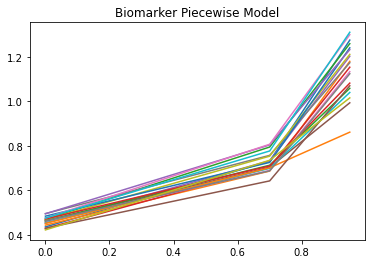

In [ ]:
# Sanity check for the piecewise biomarker model
y = []
patients = generate_patients(20)
unit_time = np.arange(0, 1, 1 / (TOTAL_OBS_PERIOD / MEASUREMENT_INTERVAL))

for pat in patients:
    biomarker = [biomarker_truth_model(pat, time) for time in unit_time]
    y = np.append(y, biomarker, axis = 0)
y = y.reshape((20,20))

for row in y:
    plt.plot(unit_time, row)
plt.title("Biomarker Piecewise Model")
plt.show()

In [ ]:
# Sanity check for patient generation
patient_records.shape, patient_records[0:3]

((200,),
 array([<__main__.patient object at 0x7f10e0e182d0>, <__main__.patient object at 0x7f10e0e184d0>, <__main__.patient object at 0x7f10e0e18990>], dtype=object))

In [ ]:
# Sanity check for longitudinal data generation, and actual measurement times
wide_data.shape, times.shape, wide_data[0,], times[0,]

((200, 25),
 (200, 20),
 array([  1.        ,   1.        ,  24.        , 171.55038728,
        211.47752043,   0.77024685,   0.48112397,   0.6090147 ,
          0.57248582,   0.41930901,   0.51063309,   0.78562174,
          0.55118942,   0.69398186,   0.76196866,   0.26049663,
          0.66265857,   1.02220983,   0.61274116,   0.74392638,
          1.03940445,   1.2094275 ,   1.29795537,   1.28649692,
          0.96121006]),
 array([0.        , 0.05306233, 0.10537708, 0.15731663, 0.21030285,
        0.26477571, 0.31674901, 0.37054105, 0.42189018, 0.47389041,
        0.52624852, 0.58068368, 0.63315824, 0.6854417 , 0.73779992,
        0.78907607, 0.84250562, 0.89512234, 0.94841726, 1.        ]))

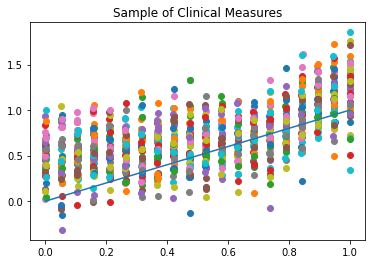

In [ ]:
measure_samples = wide_data[0:50, 5:]
time_sample = times[0:50, ]

for measures, t in zip(measure_samples, time_sample):
    plt.scatter(t, measures)

plt.title('Sample of Clinical Measures')
plt.plot(np.linspace(0, 1,num = 2))
plt.show()

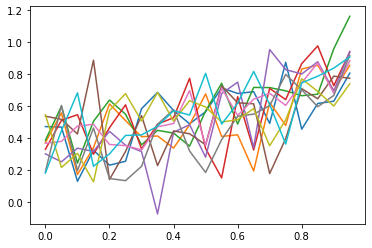

In [ ]:
for x, y in zip(Xlog[0:10, ], ylog[0:10]):
    combined = np.append(x,y)
    plt.plot(unit_time, combined)
plt.show()
# Has a slight increase but nothing substantial

# **Playground**

In [ ]:
patient_records = generate_patients(10)
wide_data, times = generate_longitudinal_dataset(patient_records, TOTAL_OBS_PERIOD, MEASUREMENT_INTERVAL)

In [ ]:
test_vec = np.array([[1,2,3,6,5],
                     [1,2,6,4,0],
                     [1,3,3,10,3],
                     [1,0,2,1,8]])

np.mean(test_vec, axis = 0)

array([1.  , 1.75, 3.5 , 5.25, 4.  ])

In [ ]:
# Columns in wide_data: 0: patient_id, 1: gender, 2: age, 3: height, 4: weight, 5+: [times...]
measurements = wide_data[:, 5:]
mmeans = np.mean(measurements, axis = 0)
y_diffed = measurements - mmeans.reshape((1, -1))
corr = np.corrcoef(measurements, rowvar = False)

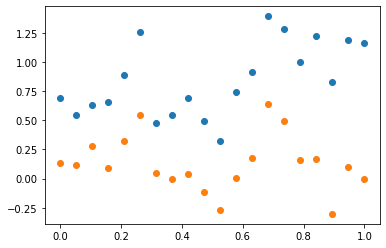

array([[1, 0.07, 0.35, 0.45, -0.04, 0.24, -0.4, 0.37, -0.66, -0.5, 0.41, 0, 0.39, 0.51, -0.06, -0.31, -0.06, -0.81, 0.21, -0.49],
       [0.07, 1, 0.3, 0.4, 0.37, -0.22, -0.35, 0.34, -0, -0.16, 0.44, 0.17, 0.23, 0.02, 0.17, 0.05, 0.38, 0.19, 0.15, 0.25],
       [0.35, 0.3, 1, 0.52, 0.51, 0.29, -0.08, -0.27, -0.22, 0.19, -0.22, 0.06, 0.32, 0.67, 0.27, 0.2, -0.02, -0.33, -0.09, -0.03],
       [0.45, 0.4, 0.52, 1, 0.54, -0.3, -0.19, 0.01, -0.18, 0.36, 0.26, -0.22, -0.08, 0.36, -0.46, -0.54, -0.2, 0.04, -0.48, 0.1],
       [-0.04, 0.37, 0.51, 0.54, 1, -0.19, -0.42, -0.07, 0.32, 0.35, -0.08, 0.37, 0.39, 0.58, -0.2, -0.23, 0.49, 0.3, -0.17, 0.25],
       [0.24, -0.22, 0.29, -0.3, -0.19, 1, 0.33, -0.05, -0.04, -0.42, -0.42, -0.26, 0.15, 0.27, 0.77, 0.56, 0.04, -0.63, 0.37, -0.26],
       [-0.4, -0.35, -0.08, -0.19, -0.42, 0.33, 1, -0.37, 0.05, 0.29, -0.3, -0.66, -0.72, -0.49, 0.31, 0.2, -0.66, 0.18, -0.52, 0.26],
       [0.37, 0.34, -0.27, 0.01, -0.07, -0.05, -0.37, 1, -0.51, -0.69, 0.69, 0.3

In [ ]:
plt.scatter(times[0,:], measurements[0,:])
plt.scatter(times[0,:], y_diffed[0,:])
plt.show()
corr.round(2)


**Test 1: Only scaling current predictor**

In [ ]:
measurements.shape, times.shape

((10, 20), (10, 20))

In [ ]:
beta = []
i, j = -1,0

# Transposing will give you all the patient measurements for a specific time
for y, t in zip(y_diffed.T, times.T):
    lm = sk.linear_model.LinearRegression(fit_intercept=False)
    model = lm.fit(t.reshape(-1, 1), y.reshape(-1, 1))
    if i == -1: 
        beta = np.append(beta, model.coef_)
        i, j = 0, 1

    else: 
        beta = np.append(beta, corr[i, j]*model.coef_)
        print(f"Correlation({i + 1}, {j + 1}): {corr[i, j]}, Beta: {model.coef_}")
        i+= 1; j += 1

Correlation(1, 2): 0.07253697796681835, Beta: [[-0.0391]]
Correlation(2, 3): 0.29884508510099106, Beta: [[-0.000578]]
Correlation(3, 4): 0.5177542175173117, Beta: [[0.00206]]
Correlation(4, 5): 0.537005276285886, Beta: [[-0.00156]]
Correlation(5, 6): -0.18899410415984086, Beta: [[-0.000118]]
Correlation(6, 7): 0.33065718540973005, Beta: [[0.00258]]
Correlation(7, 8): -0.37297175791030673, Beta: [[0.000412]]
Correlation(8, 9): -0.5061834352679996, Beta: [[-0.00024]]
Correlation(9, 10): 0.45584266118381817, Beta: [[-0.000149]]
Correlation(10, 11): -0.4941582868959325, Beta: [[0.000506]]
Correlation(11, 12): 0.2721848032298092, Beta: [[-0.00013]]
Correlation(12, 13): 0.6580777148144572, Beta: [[-0.000113]]
Correlation(13, 14): 0.6362423025851807, Beta: [[-0.000238]]
Correlation(14, 15): 0.12170829623793972, Beta: [[-0.000154]]
Correlation(15, 16): 0.7357573351656529, Beta: [[-0.000124]]
Correlation(16, 17): 0.21238936340285436, Beta: [[-0.000104]]
Correlation(17, 18): 0.0668229825265093, 

In [ ]:
beta

array([-84.2, -0.00283, -0.000173, 0.00107, -0.000838, 2.22e-05, 0.000853, -0.000154, 0.000121, -6.81e-05, -0.00025, -3.55e-05, -7.46e-05, -0.000151, -1.87e-05, -9.1e-05, -2.21e-05, 9.62e-06, 5.03e-05, -2.76e-17])

In [ ]:
test_patients = generate_patients(5)
twd, t2 = generate_longitudinal_dataset(test_patients, TOTAL_OBS_PERIOD, MEASUREMENT_INTERVAL)
measurements2 = twd[:, 5:]
mmeans2 = np.mean(measurements2,  axis = 0)
y_diffed_test = measurements2 - mmeans2.reshape((1, -1))

In [ ]:
vals = []
dist = []

for y, t in zip(y_diffed_test, t2):
    temp = beta*t
    vals = np.append(vals, temp)
    dist = np.append(dist, y - temp)

vals = vals.reshape((5, 20))
print(vals)

[[-0.0814 -0.000146 -1.83e-05 0.000168 -0.000175 5.86e-06 0.000269 -5.66e-05 5.09e-05 -3.21e-05 -0.000131 -2.05e-05 -4.7e-05 -0.000103 -1.38e-05 -7.18e-05 -1.85e-05 8.59e-06 4.76e-05 -2.76e-17]
 [-0.00792 -0.00015 -1.82e-05 0.00017 -0.000176 5.82e-06 0.00027 -5.66e-05 5.11e-05 -3.23e-05 -0.000131 -2.05e-05 -4.71e-05 -0.000103 -1.38e-05 -7.18e-05 -1.86e-05 8.58e-06 4.77e-05 -2.76e-17]
 [-0 -0.000147 -1.84e-05 0.000166 -0.000177 5.87e-06 0.00027 -5.65e-05 5.12e-05 -3.22e-05 -0.000132 -2.06e-05 -4.72e-05 -0.000104 -1.38e-05 -7.2e-05 -1.86e-05 8.6e-06 4.78e-05 -2.76e-17]
 [-0 -0.00015 -1.83e-05 0.000169 -0.000177 5.89e-06 0.00027 -5.64e-05 5.1e-05 -3.23e-05 -0.000131 -2.05e-05 -4.71e-05 -0.000104 -1.38e-05 -7.18e-05 -1.86e-05 8.59e-06 4.76e-05 -2.76e-17]
 [-0 -0.00015 -1.8e-05 0.00017 -0.000175 5.88e-06 0.000269 -5.68e-05 5.11e-05 -3.23e-05 -0.000132 -2.05e-05 -4.71e-05 -0.000104 -1.38e-05 -7.17e-05 -1.86e-05 8.61e-06 4.76e-05 -2.76e-17]]


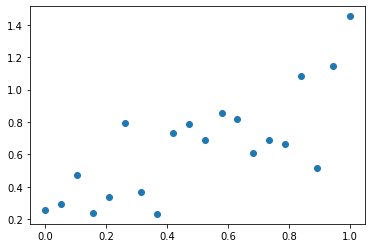

In [ ]:
plt.scatter(t2[0,:], measurements2[0, :])
plt.show()

(array([9, 8, 3]),
 array([0.232, 0.639, 1.05, 1.45]),
 <a list of 3 Patch objects>)

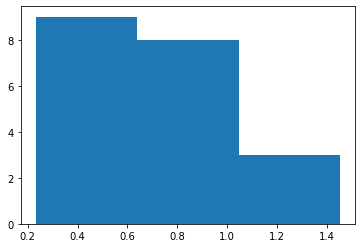

In [ ]:
plt.hist(measurements2[0, :], 3)

In [ ]:
data = grunfeld.load_pandas().data
data.head()

,invest,value,capital,firm,year
0,317.6,3078.5,2.8,General Motors,1935.0
1,391.8,4661.7,52.6,General Motors,1936.0
2,410.6,5387.1,156.9,General Motors,1937.0
3,257.7,2792.2,209.2,General Motors,1938.0
4,330.8,4313.2,203.4,General Motors,1939.0


In [ ]:
long_data = wide_to_long(wide_data, times)
long_df = pd.DataFrame(long_data[0:-1, :], columns = ['patientid', 'gender', 'age', 'height', 'weight', 'unittime', 'biomarker'])
targets = long_df['biomarker'].shift(-1).iloc[0:-1]
targets = targets.rename('targets')
long_df = pd.concat([long_df, targets], axis = 1)
targets.head()

0    0.429136
1    0.431950
2    0.676303
3    0.372590
4    0.406419
Name: targets, dtype: float64

In [ ]:
long_df.head(), long_df.shape

(   patientid  gender   age      height      weight  unittime  biomarker  \
 0        1.0     1.0  30.0  169.962231  200.742919  0.000365   0.489171   
 1        1.0     1.0  30.0  169.962231  200.742919  0.052422   0.429136   
 2        1.0     1.0  30.0  169.962231  200.742919  0.105034   0.431950   
 3        1.0     1.0  30.0  169.962231  200.742919  0.157900   0.676303   
 4        1.0     1.0  30.0  169.962231  200.742919  0.210942   0.372590   
 
     targets  
 0  0.429136  
 1  0.431950  
 2  0.676303  
 3  0.372590  
 4  0.406419  , (3999, 8))

In [ ]:
gp_model = gpb.GPModel(group_data=long_df[['patientid', 'unittime']])
data_train = gpb.Dataset(data=long_df['biomarker'].values.reshape((-1,1)), label=long_df['targets'].values)
long_df['targets'].shape, long_df['biomarker'].shape

((3999,), (3999,))

In [ ]:
params = { 'objective': 'regression_l2',
            'learning_rate': 0.005,
            'max_depth': 6,
            'min_data_in_leaf': 1,
            'verbose': 1}
# Train GPBoost model
bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=500)
# Estimated random effects model (variances of random effects)
cvbst = gpb.cv(params=params, 
               train_set=data_train,
               gp_model=gp_model, 
               use_gp_model_for_validation=True,
               num_boost_round=300, 
               early_stopping_rounds=5,
               nfold=5, 
               verbose_eval=True, 
               show_stdv=False, 
               seed=42)
gp_model.summary()

[GPBoost] [Info] Total Bins 255
[GPBoost] [Info] Number of data points in the train set: 3999, number of used features: 1
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=0.716765
[GPBoost] [Info] Start training from score 0.716765
[GPBoost] [Info] Total Bins 255
[GPBoost] [Info] Number of data points in the train set: 3196, number of used features: 1
[GPBoost] [Info] Total Bins 255
[GPBoost] [Info] Number of data points in the train set: 3196, number of used features: 1
[GPBoost] [Info] Total Bins 255
[GPBoost] [Info] Number of data points in the train set: 3196, number of used features: 1
[GPBoost] [Info] Total Bins 255
[GPBoost] [Info] Number of data points in the train set: 3196, number of used features: 1
[GPBoost] [Info] Total Bins 255
[GPBoost] [Info] Number of data points in the train set: 3196, number of used features: 1
[1]	cv_agg's l2: 0.106086
[2]	cv_agg's l2: 0.104909
[3]	cv_agg's l2: 0.103832
[4]	cv_agg's l2: 0.102803
[5]	cv_agg's l2: 0.10187
[6]	cv_agg's l2

In [ ]:
print("Best number of iterations: " + str(np.argmin(cvbst['l2-mean'])))

Best number of iterations: 44


# **LINSPACE >>>>>>>>>> ARANGE**
Thank you for coming to my TED talk.

In [ ]:
long_data = wide_to_long(wide_data, times)
pid = pd.Categorical(long_data[:, 0]).reshape((-1,1))
measurement_means = np.mean(wide_data[:, 5:], axis = 0)
t_time = np.linspace(0, 1, num = 20)
# Try with and without fitting intercept
lm = sk.linear_model.LinearRegression(fit_intercept=False)
lm_fit = lm.fit(measurement_means.reshape(-1, 1), t_time.reshape(-1, 1))
targets = lm_fit.predict(long_data[:, 5].reshape(-1, 1))

In [ ]:
lm_fit.coef_, lm_fit.intercept_

(array([[0.749]]), 0.0)

In [ ]:
# Columns in long_data: 0: patient_id, 1: gender, 2: age, 3: height, 4: weight, 5: time, 6: measure
X, y = long_data[:, 5:], targets.flatten()
regr = make_pipeline(StandardScaler(),
                    LinearSVR(C = 10000, random_state=0, tol=1e-5))
regr.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr', LinearSVR(C=10000, random_state=0, tol=1e-05))])

In [ ]:
test_patients = generate_patients(50)
twd, t2 = generate_longitudinal_dataset(test_patients, TOTAL_OBS_PERIOD, MEASUREMENT_INTERVAL)
long_test = wide_to_long(twd, t2)
test_means = np.mean(twd[:, 5:], axis = 0)
lm = sk.linear_model.LinearRegression(fit_intercept=False)
lm_fit = lm.fit(test_means.reshape(-1, 1), t_time.reshape(-1, 1))
test_targets = lm_fit.predict(long_test[:, 5].reshape(-1, 1))
long_test.shape, test_targets.shape, twd.shape

((1000, 7), (1000, 1), (50, 25))

In [ ]:
predictions = regr.predict(long_test[:, 5:])
regr.score(long_test[:, 5:], test_targets.flatten())

0.9999442434843769

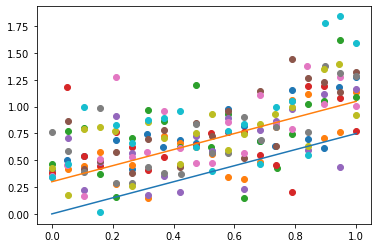

In [ ]:
plt.plot(t2[0, :],predictions[0:20])
plt.plot(t2[0, :],predictions[0:20] + 0.3)
for i in range(10):
    plt.scatter(t2[i, :], twd[i, 5:])
plt.show()

In [ ]:
long_test[0:20, 6]

array([0.231, 0.357, 0.201, 0.448, 0.11, 0.504, 0.566, 0.96, 0.43, 1.1, 0.561, 0.671, 0.662, 1.01, 0.824, 1.23, 1.3, 0.867, 0.891, 0.799])

In [ ]:
[i for i in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]